# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-и-исследовательский-анализ-данных" data-toc-modified-id="Предобработка-и-исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка и исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li></ul></li><li><span><a href="#Расчет-прибыли" data-toc-modified-id="Расчет-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Расчет прибыли</a></span></li><li><span><a href="#Разработка-модели-ML" data-toc-modified-id="Разработка-модели-ML-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Разработка модели ML</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Проверка-лучшей-модели-и-оценка-прибыли" data-toc-modified-id="Проверка-лучшей-модели-и-оценка-прибыли-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Проверка лучшей модели и оценка прибыли</a></span></li></ul></li><li><span><a href="#Признаки-«ненадёжного»-клиента" data-toc-modified-id="Признаки-«ненадёжного»-клиента-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Признаки «ненадёжного» клиента</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Обзор данных

Импортируем бибилиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, recall_score
from sklearn import tree

Считаем датасеты и сохраним в переменные:

In [2]:
try:
    hotel_train = pd.read_csv('/datasets/hotel_train.csv')
    hotel_test = pd.read_csv('/datasets/hotel_test.csv')
except:
    hotel_train = pd.read_csv('hotel_train.csv')
    hotel_test = pd.read_csv('hotel_test.csv')

Выведем на экран первые, последние и случайные пять строк каждой таблицы, а также общую информацию. Создадим для этого собственную функцию и применим ее к датасетам:

In [3]:
def total_view(df, n_rows=5, seed=None):
    '''Возвращает первые, случайные и последние строки таблицы (по умолчанию по 5 строк)'''
    return pd.concat([df.head(n_rows),
                      df.sample(n_rows,random_state=seed),
                      df.tail(n_rows)
                     ])
# cброс ограничений на количество выводимых колонок
pd.set_option('display.max_columns', None)

display(total_view(hotel_train), hotel_train.describe().T)
hotel_train.info()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3
60555,79233,0,6.0,2016,November,48,23,0,2,1.0,0.0,0.0,BB,PRT,Corporate,1,0,1,A,0,0,Transient,0,1,2
60824,79504,0,338.0,2016,October,41,7,1,2,2.0,0.0,0.0,BB,DOM,TA/TO,0,0,0,A,0,68,Transient-Party,0,1,3
48963,67456,0,67.0,2016,April,14,2,2,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,4
33608,41548,1,111.0,2016,October,42,10,1,0,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient-Party,0,0,1
10025,12543,0,21.0,2016,February,6,4,1,3,1.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient-Party,0,2,4


,count,mean,std,min,25%,50%,75%,max
id,65229.0,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

В датасете `hotel_train.csv` 25 колонок и 65229 строк. Тип данных в колонках float64, int64 и object, соответствует содержащимся в них типам данных. 

Согласно документации к данным, к признаками относятся следующие колонки:

* `id` — номер записи;
* `adults` — количество взрослых постояльцев;
* `arrival_date_year` — год заезда;
* `arrival_date_month` — месяц заезда;
* `arrival_date_week_number` — неделя заезда;
* `arrival_date_day_of_month` — день заезда;
* `babies` — количество младенцев;
* `booking_changes` — количество изменений параметров заказа;
* `children` — количество детей от 3 до 14 лет;
* `country` — гражданство постояльца;
* `customer_type` — тип заказчика:
    - `Contract` — договор с юридическим лицом;
    - `Group` — групповой заезд;
    - `Transient` — не связано с договором или групповым заездом;
    - `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа `Transient`.
* `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
* `distribution_channel` — канал дистрибуции заказа;
* `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
* `lead_time` — количество дней между датой бронирования и датой прибытия;
* `meal` — опции заказа:
    - `SC` — нет дополнительных опций;
    - `BB` — включён завтрак;
    - `HB` — включён завтрак и обед;
    - `FB` — включён завтрак, обед и ужин.
* `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
* `previous_cancellations` — количество отменённых заказов у клиента;
* `required_car_parking_spaces` — необходимость места для автомобиля;
* `reserved_room_type` — тип забронированной комнаты;
* `stays_in_weekend_nights` — количество ночей в выходные дни;
* `stays_in_week_nights` — количество ночей в будние дни;
* `total_nights` — общее количество ночей;
* `total_of_special_requests` — количество специальных отметок.

Целевой признак:

* `is_canceled` — отмена заказа.

Пропущенные значения отсутствуют.

Данные требуют проверку на выбросы и дубликаты:
- в колонке `babies` максимальное значение 10 младенцев - похоже на опечатку;
- в колонках со строковыми данными проверить уникальные значения на неявные дубликаты.

In [4]:
display(total_view(hotel_test), hotel_test.describe().T)
hotel_test.info()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7
25970,91462,0,19.0,2017,May,20,14,2,0,2.0,0.0,0.0,BB,IRL,Direct,0,0,0,D,0,0,Transient,0,0,2
17816,55005,1,195.0,2017,August,33,19,2,1,3.0,0.0,0.0,BB,USA,TA/TO,0,0,0,D,1,0,Transient,0,0,3
17580,54769,1,118.0,2017,August,33,14,1,3,2.0,0.0,0.0,SC,FRA,TA/TO,0,0,0,A,0,0,Transient,0,1,4
1392,7497,1,310.0,2017,June,22,3,2,5,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,D,0,0,Transient-Party,0,0,7
1148,7250,1,52.0,2017,May,19,12,1,2,2.0,2.0,0.0,BB,ESP,TA/TO,0,0,0,C,0,0,Transient,0,1,3


,count,mean,std,min,25%,50%,75%,max
id,32412.0,60131.505183,29953.586177,6086.0,45291.75,53394.5,89800.25,97903.0
is_canceled,32412.0,0.388467,0.487409,0.0,0.00,0.0,1.00,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.00,76.0,155.00,373.0
arrival_date_year,32412.0,2017.000000,0.000000,2017.0,2017.00,2017.0,2017.00,2017.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.00,18.0,25.00,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.00,15.5,23.00,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.00,1.0,2.00,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.00,2.0,3.00,6.0
adults,32412.0,1.858602,0.489341,0.0,2.00,2.0,2.00,4.0
children,32412.0,0.083765,0.343470,0.0,0.00,0.0,0.00,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

В датасете `hotel_test.csv` 25 колонок и 32412 строк. Тип данных в колонках float64, int64 и object, соответствует содержащимся в них типам данных. 

В колонках содержатся данные, аналогичные датасету `hotel_train.csv`.

Пропущенные значения отсутствуют.

Данные также требуют проверку на явные и неявные дубликаты.

**Вывод:**

* в обоих датасетах содержатся данные о бронированиях в отеле. Каждая строка содержит данные об одном бронировании, к целевому признаку относится колонка `is_canceled`;
* пропущенные значения отсутствуют;
* данные требуют проверку на выбросы, дубликаты и неявные дубликаты.

## Предобработка и исследовательский анализ данных

Посмотрим на выбросы в колонкех `babies` датафрейма `hotel_train`:

In [5]:
hotel_train[hotel_train['babies'] > 2]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,0.0,10.0,BB,PRT,TA/TO,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,0.0,9.0,BB,GBR,Corporate,0,0,0,A,1,0,Transient-Party,0,0,3


Всего две записи, где на 1-2 взрослых 9-10 младенцев. Удалим эти строки:

In [6]:
hotel_train = hotel_train[hotel_train['babies'] < 3]

Проверим строковые данные на неявные дубликаты:

In [7]:
object_list = ['arrival_date_month',
               'meal',
               'country',
               'distribution_channel',
               'reserved_room_type',
               'customer_type']
for column in object_list:
    print(column, hotel_train[column].unique())
    print()

arrival_date_month ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

meal ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']

country ['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'L

В колонке `meal` есть неявные дубликаты `'SC       '` и `'SC'`. Устраним их удалив лишние пробелы в `meal` и `reserved_room_type`:

In [8]:
for column in ['meal', 'reserved_room_type']:
    hotel_train[column] = hotel_train[column].apply(lambda x: x.strip())
    print(column, hotel_train[column].unique())

meal ['BB' 'FB' 'HB' 'SC']
reserved_room_type ['A' 'C' 'D' 'E' 'G' 'F' 'B']


Проверим данные на дубликаты:

In [9]:
print('hotel_train', hotel_train.duplicated().sum())
print('hotel_test', hotel_test.duplicated().sum())

hotel_train 0
hotel_test 0


Удалим колонку `id`, так как там содержатся уникальные значения, не связанные с целевым признаком:

In [10]:
hotel_train = hotel_train.drop('id', axis=1)
hotel_test = hotel_test.drop('id', axis=1)

Проверим строковые данные датафрейма `hotel_test` на неявные дубликаты:

In [11]:
for column in object_list:
    print(column, hotel_test[column].unique())
    print()

arrival_date_month ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']

meal ['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']

country ['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'
 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'
 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'
 'MAC' 'CYP' 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'VEN' 'SEN' 'BLR'
 'TZA' 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT'
 'ECU' 'AND' 'IMN' 'BHR' 'TUN' 'MNE' 'MEX' 'BEN' 'MOZ' 'UMI' 'JEY' 'MYT'
 'QAT' 'BGD' 'GAB' 'CIV' 'ZWE' 'GTM' 'ALB' 'GHA' 'ATA' 'ASM' 'PAN' 'CRI'
 'MCO' 'MUS' 'SYR' 'TGO' 'IRQ' 'LKA' 'BIH' 'PRY' 'MRT' 'ABW' 'NCL' 'STP'
 'KIR' 'SDN' 'PRI' 'ATF' 'CMR' 'TJK' 'LBY

Здесь также присутствуют лишние пробелы в `meal` и `reserved_room_type`. Устраним их:

In [12]:
for column in ['meal', 'reserved_room_type']:
    hotel_test[column] = hotel_test[column].apply(lambda x: x.strip())
    print(column, hotel_test[column].unique())

meal ['BB' 'HB' 'SC' 'FB']
reserved_room_type ['A' 'E' 'G' 'D' 'F' 'C' 'B']


Посмотрим на выбросы в `hotel_train` и `hotel_test` в колонках `lead_time`, `previous_cancellations`, `previous_bookings_not_canceled`, `booking_change`, `days_in_waiting_list`. Все остальные данные, судя по значениям из таблицы `describe` выглядят нормально:

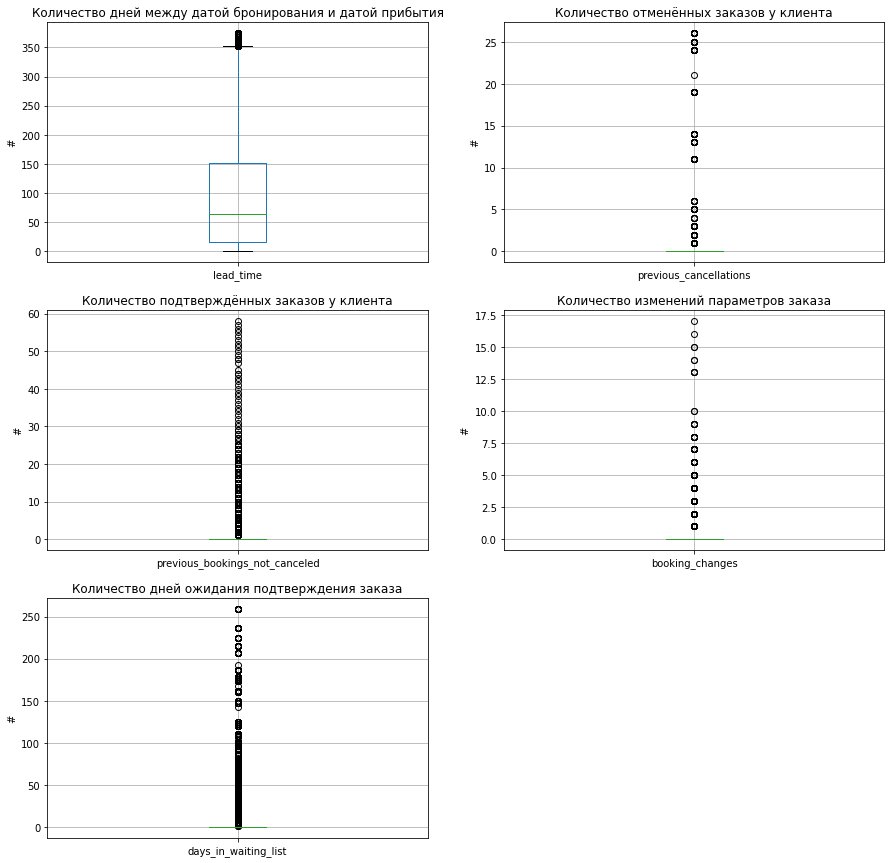

In [13]:
column_list = ['lead_time', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes',
               'days_in_waiting_list']
cnt = 1
plt.figure(figsize=(15, 15))
for column in column_list:
    plt.subplot(3, 2, cnt)
    hotel_train.boxplot(column)
    plt.ylabel('#')
    if cnt == 1:
        plt.title('Количество дней между датой бронирования и датой прибытия')
    if cnt == 2:
        plt.title('Количество отменённых заказов у клиента')
    if cnt == 3:
        plt.title('Количество подтверждённых заказов у клиента')
    if cnt == 4:
        plt.title('Количество изменений параметров заказа')
    if cnt == 5:
        plt.title('Количество дней ожидания подтверждения заказа')
    cnt += 1

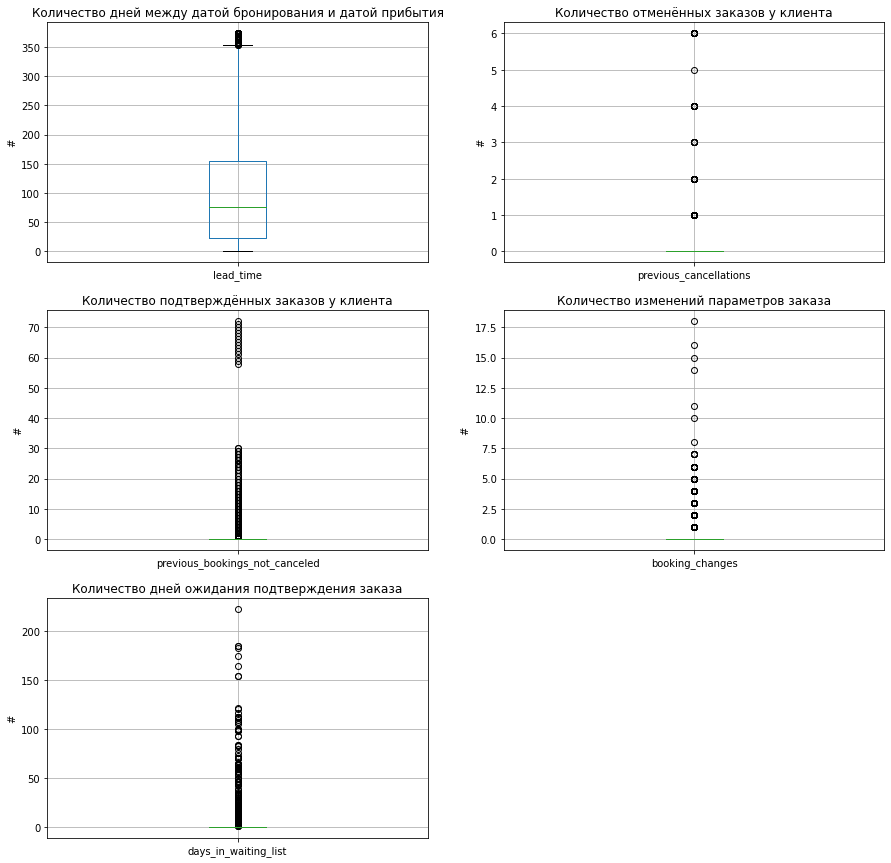

In [14]:
cnt = 1
plt.figure(figsize=(15, 15))
for column in column_list:
    plt.subplot(3, 2, cnt)
    hotel_test.boxplot(column)
    plt.ylabel('#')
    if cnt == 1:
        plt.title('Количество дней между датой бронирования и датой прибытия')
    if cnt == 2:
        plt.title('Количество отменённых заказов у клиента')
    if cnt == 3:
        plt.title('Количество подтверждённых заказов у клиента')
    if cnt == 4:
        plt.title('Количество изменений параметров заказа')
    if cnt == 5:
        plt.title('Количество дней ожидания подтверждения заказа')
    cnt += 1

Во всех рассмотренных колонках наблюдаются выбросы. В колонке `lead_time` в выбросы попадают значения от 352 до 374 дней, это чуть больше года и не так сильно выбивается от верхней границы уса. В `hotel_test` похожая картина. Эти выбросы похожи либо на действительно раннее бронирование (до 365 дней), либо ошибку гостя в годе заезда (после 365 дней). В обоих случаях вероятность отмены брони выше, чем в более короткий срок. Оставим эти данные для обучения модели.

В колонках `previous_cancellations`, `previous_bookings_not_canceled`, `booking_change` и `days_in_waiting_list` в выбросы попали все значения, отличные от нуля, так как в них содержатся преимущественно нулевые значения. Также оставим их для обучения.

Объединим страны, встречающиеся менее 5 раз в каждом датасете в группу 'OTHER':

In [15]:
hotel_common = pd.concat([hotel_train, hotel_test])
values = hotel_common['country'].value_counts(dropna=False)
country_list = values[values < 5].index
hotel_common.loc[hotel_common['country'].isin(country_list), 'country']= 'OTHER'

In [16]:
hotel_common[hotel_common['country'] =='OTHER']

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
297,0,91.0,2015,July,29,17,1,2,2.0,1.0,0.0,BB,OTHER,TA/TO,0,0,0,A,3,0,Transient,0,3,3
879,0,154.0,2015,September,36,3,0,3,2.0,0.0,0.0,BB,OTHER,Direct,0,0,0,A,0,0,Transient-Party,0,0,3
1558,0,92.0,2015,October,43,22,1,3,2.0,0.0,0.0,BB,OTHER,TA/TO,0,0,0,A,0,0,Transient-Party,0,2,4
1799,0,15.0,2015,November,45,6,0,2,2.0,0.0,0.0,BB,OTHER,TA/TO,0,0,0,A,0,0,Transient,0,0,2
5866,1,16.0,2016,December,50,8,0,1,1.0,0.0,0.0,BB,OTHER,TA/TO,0,0,0,A,0,0,Transient-Party,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31217,0,2.0,2017,August,32,9,0,3,2.0,0.0,0.0,BB,OTHER,TA/TO,0,0,0,D,0,0,Transient,0,1,3
31218,0,3.0,2017,August,32,10,0,2,2.0,0.0,0.0,BB,OTHER,TA/TO,0,0,0,D,0,0,Transient,0,1,2
31305,0,5.0,2017,August,33,13,1,0,2.0,0.0,0.0,BB,OTHER,TA/TO,0,0,0,A,0,0,Transient,0,0,1
31559,0,77.0,2017,August,33,15,0,4,2.0,0.0,0.0,BB,OTHER,Direct,0,0,0,D,0,0,Transient,0,0,4


### Подготовка признаков

Преобразуем категориальные признаки в численные с помощью техники прямого кодирования (One-Hot Encoding). Так как уникальные значения признаков в колонках `arrival_date_month` и `country` между датасетами различаются, применим `get_dummies()` к объединенному датасету, а затем разделим его:

In [17]:
hotel_ohe = pd.get_dummies(hotel_common, drop_first=True)
train_ohe = hotel_ohe[hotel_ohe['arrival_date_year'] != 2017]
test_ohe = hotel_ohe[hotel_ohe['arrival_date_year'] == 2017]

In [18]:
train_ohe.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_ALB,country_ARE,country_ARG,country_ARM,country_AUS,country_AUT,country_AZE,country_BEL,country_BGD,country_BGR,country_BIH,country_BLR,country_BOL,country_BRA,country_CHE,country_CHL,country_CHN,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CYP,country_CZE,country_DEU,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_FIN,country_FRA,country_GBR,country_GEO,country_GIB,country_GNB,country_GRC,country_HKG,country_HRV,country_HUN,country_IDN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KOR,country_KWT,country_LBN,country_LBY,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MDV,country_MEX,country_MKD,country_MLT,country_MNE,country_MOZ,country_MUS,country_MYS,country_NGA,country_NLD,country_NOR,country_NZL,country_OMN,country_OTHER,country_PAK,country_PAN,country_PER,country_PHL,country_POL,country_PRI,country_PRT,country_QAT,country_ROU,country_RUS,country_SAU,country_SEN,country_SGP,country_SRB,country_SUR,country_SVK,country_SVN,country_SWE,country_THA,country_TJK,country_TUN,country_TUR,country_TWN,country_UKR,country_URY,country_USA,country_VEN,country_VNM,country_ZAF,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,7.0,2015,27,1,0,1,1.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,14.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
3,0,9.0,2015,27,1,0,2,2.0,0.0,0.0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,1,85.0,2015,27,1,0,3,2.0,0.0,0.0,0,0,0,0,0,0,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [19]:
test_ohe.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_ALB,country_ARE,country_ARG,country_ARM,country_AUS,country_AUT,country_AZE,country_BEL,country_BGD,country_BGR,country_BIH,country_BLR,country_BOL,country_BRA,country_CHE,country_CHL,country_CHN,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CYP,country_CZE,country_DEU,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_FIN,country_FRA,country_GBR,country_GEO,country_GIB,country_GNB,country_GRC,country_HKG,country_HRV,country_HUN,country_IDN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KOR,country_KWT,country_LBN,country_LBY,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MDV,country_MEX,country_MKD,country_MLT,country_MNE,country_MOZ,country_MUS,country_MYS,country_NGA,country_NLD,country_NOR,country_NZL,country_OMN,country_OTHER,country_PAK,country_PAN,country_PER,country_PHL,country_POL,country_PRI,country_PRT,country_QAT,country_ROU,country_RUS,country_SAU,country_SEN,country_SGP,country_SRB,country_SUR,country_SVK,country_SVN,country_SWE,country_THA,country_TJK,country_TUN,country_TUR,country_TWN,country_UKR,country_URY,country_USA,country_VEN,country_VNM,country_ZAF,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,74.0,2017,1,1,1,0,2.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,62.0,2017,1,1,2,2,2.0,0.0,0.0,0,0,0,0,0,0,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,62.0,2017,1,1,2,2,2.0,0.0,0.0,0,0,0,0,0,0,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1,71.0,2017,1,1,2,2,1.0,0.0,0.0,0,0,0,0,0,0,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,172.0,2017,1,1,2,5,2.0,0.0,0.0,0,0,0,0,0,0,0,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


Выделим целевой признак:

In [20]:
feature_train = train_ohe.drop('is_canceled', axis=1)
target_train = train_ohe['is_canceled']
feature_test = test_ohe.drop('is_canceled', axis=1)
target_test = test_ohe['is_canceled']

print('feature_train:',feature_train.shape, '\n',
      'target_train:', target_train.shape, '\n',
      'feature_test:', feature_test.shape, '\n',
      'target_test:', target_test.shape)

feature_train: (65227, 151) 
 target_train: (65227,) 
 feature_test: (32412, 151) 
 target_test: (32412,)


Проведем масштабирование численных признаков: 

In [21]:
pd.options.mode.chained_assignment = None

numeric = ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month',
           'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest',
           'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
           'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', ]

scaler = StandardScaler()
scaler.fit(feature_train[numeric])
feature_train[numeric] = scaler.transform(feature_train[numeric])
feature_test[numeric] = scaler.transform(feature_test[numeric])

In [22]:
feature_train.head()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_ALB,country_ARE,country_ARG,country_ARM,country_AUS,country_AUT,country_AZE,country_BEL,country_BGD,country_BGR,country_BIH,country_BLR,country_BOL,country_BRA,country_CHE,country_CHL,country_CHN,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CYP,country_CZE,country_DEU,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_FIN,country_FRA,country_GBR,country_GEO,country_GIB,country_GNB,country_GRC,country_HKG,country_HRV,country_HUN,country_IDN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KOR,country_KWT,country_LBN,country_LBY,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MDV,country_MEX,country_MKD,country_MLT,country_MNE,country_MOZ,country_MUS,country_MYS,country_NGA,country_NLD,country_NOR,country_NZL,country_OMN,country_OTHER,country_PAK,country_PAN,country_PER,country_PHL,country_POL,country_PRI,country_PRT,country_QAT,country_ROU,country_RUS,country_SAU,country_SEN,country_SGP,country_SRB,country_SUR,country_SVK,country_SVN,country_SWE,country_THA,country_TJK,country_TUN,country_TUR,country_TWN,country_UKR,country_URY,country_USA,country_VEN,country_VNM,country_ZAF,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.929393,-1.599708,-0.322354,-1.697254,-0.966858,-0.903927,-1.742026,-0.224064,-0.083075,-0.16706,-0.133549,-0.081194,-0.327107,-0.182816,-0.244073,-0.681330,-1.179435,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,-0.856573,-1.599708,-0.322354,-1.697254,-0.966858,-0.165916,0.340277,-0.224064,-0.083075,-0.16706,-0.133549,-0.081194,-0.327107,-0.182816,-0.244073,0.647413,-0.604099,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,-1.002213,-1.599708,-0.322354,-1.697254,-0.966858,-0.165916,0.340277,-0.224064,-0.083075,-0.16706,-0.133549,-0.081194,-0.327107,-0.182816,-0.244073,-0.681330,-0.604099,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
3,-0.908587,-1.599708,-0.322354,-1.697254,-0.966858,-0.165916,0.340277,-0.224064,-0.083075,-0.16706,-0.133549,-0.081194,-0.327107,-0.182816,-0.244073,0.647413,-0.604099,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,-0.117970,-1.599708,-0.322354,-1.

In [23]:
feature_test.head()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_ALB,country_ARE,country_ARG,country_ARM,country_AUS,country_AUT,country_AZE,country_BEL,country_BGD,country_BGR,country_BIH,country_BLR,country_BOL,country_BRA,country_CHE,country_CHL,country_CHN,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CYP,country_CZE,country_DEU,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_FIN,country_FRA,country_GBR,country_GEO,country_GIB,country_GNB,country_GRC,country_HKG,country_HRV,country_HUN,country_IDN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KOR,country_KWT,country_LBN,country_LBY,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MDV,country_MEX,country_MKD,country_MLT,country_MNE,country_MOZ,country_MUS,country_MYS,country_NGA,country_NLD,country_NOR,country_NZL,country_OMN,country_OTHER,country_PAK,country_PAN,country_PER,country_PHL,country_POL,country_PRI,country_PRT,country_QAT,country_ROU,country_RUS,country_SAU,country_SEN,country_SGP,country_SRB,country_SUR,country_SVK,country_SVN,country_SWE,country_THA,country_TJK,country_TUN,country_TUR,country_TWN,country_UKR,country_URY,country_USA,country_VEN,country_VNM,country_ZAF,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.232401,2.849936,-2.253486,-1.697254,0.204836,-1.641937,0.340277,-0.224064,-0.083075,-0.16706,-0.133549,-0.081194,-0.327107,-0.182816,-0.244073,-0.681330,-1.179435,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,-0.357236,2.849936,-2.253486,-1.697254,1.376530,-0.165916,0.340277,-0.224064,-0.083075,-0.16706,-0.133549,-0.081194,-0.327107,-0.182816,-0.244073,0.647413,0.546572,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,-0.357236,2.849936,-2.253486,-1.697254,1.376530,-0.165916,0.340277,-0.224064,-0.083075,-0.16706,-0.133549,-0.081194,-0.327107,-0.182816,-0.244073,0.647413,0.546572,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,-0.263610,2.849936,-2.253486,-1.697254,1.376530,-0.165916,-1.742026,-0.224064,-0.083075,-0.16706,-0.133549,-0.081194,-0.327107,-0.182816,-0.244073,0.647413,0.546572,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0.787079,2.849936,-2.253486,-1.697254,1.37653

**Вывод:**

На этапе предобработки данных были:
* удалены строки с аномальным количеством младенцев в номере (9 и 10);
* устранены неявные дубликаты в колонке `meal` и удалены лишние пробелы в `reserved_room_type` для удобства;
* преобразованы категориальные признаки с помощью техники OHE;
* выделен целевой признак;
* проведено масштабирование численных признаков.

## Расчет прибыли

Создадим константы, напишем функцию для расчета прибыли и расчитаем прибыль на тестовой выборке без внедрения депозита:

In [25]:
PRICE = {'A': [1000, 400],
         'B': [800, 350],
         'C': [600, 350],
         'D': [550, 150],
         'E': [500, 150],
         'F': [450, 150],
         'G': [350, 150]
        }
COEF = {'December': 1, 'January': 1, 'February': 1, 'March': 1.2, 'April': 1.2, 'May': 1.2,
        'June': 1.4, 'July': 1.4, 'August': 1.4, 'September': 1.2, 'October': 1.2, 'November': 1.2
       }
BUDGET = 400_000
    
def profit(row):
    '''Вовращает прибыль/убыток с номера'''
    revenue = 0
    if row['is_canceled'] == 1:
        if row['is_canceled'] == row['predictions']:
            revenue += (0.8 * COEF[row['arrival_date_month']] \
                        * PRICE[row['reserved_room_type']][0] \
                        - 0.2 * PRICE[row['reserved_room_type']][1])
        else:
            revenue -= PRICE[row['reserved_room_type']][1]
    else:
        revenue += (COEF[row['arrival_date_month']] \
                    * PRICE[row['reserved_room_type']][0] \
                    * row['total_nights'] \
                    - PRICE[row['reserved_room_type']][1] \
                    * ((row['total_nights'] - 1 // 2) + 1))
    return revenue

In [26]:
hotel_test['predictions'] = 0
hotel_test['profit'] = hotel_test.apply(profit, axis = 1)
profit_without_deposit = hotel_test['profit'].sum()
profit_without_deposit

34391030.0

**Вывод:**

Прибыль отеля по тестовой выборке до внедрения депозита составила примерно 34,4 млн. руб.

## Разработка модели ML

Посмотрим на баланс классов:

In [27]:
hotel_train['is_canceled'].value_counts()

0    41183
1    24044
Name: is_canceled, dtype: int64

Классы не сбалансированы, будем учитывать это при построении моделей и оценивать их качество с помощью F1-меры.

### Логистическая регрессия

In [28]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
scores = cross_val_score(model_lr, feature_train, target_train, cv=5, scoring='f1')
final_score = scores.mean()

print('Средняя оценка качества модели (f1):', final_score)

Средняя оценка качества модели (f1): 0.513410683563692


In [29]:
scores

array([0.66911765, 0.45859274, 0.39921466, 0.41341092, 0.62671745])

### Решающее дерево

In [30]:
parameters = {'max_depth': range(1, 20)}
model_tree_gs = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
grid = GridSearchCV(model_tree_gs, parameters, cv=5, scoring='f1')
grid.fit(feature_train, target_train)

model_tree = grid.best_estimator_
print(grid.best_params_, f'Средняя оценка качества модели (f1): {grid.best_score_}', sep='\n')

{'max_depth': 2}
Средняя оценка качества модели (f1): 0.6581723810304376


### Случайный лес

In [31]:
parameters = {'n_estimators': range(1, 100, 20),
              'max_depth': range(1, 20, 5)
             }
model_rf_gs = RandomForestClassifier(random_state=12345, class_weight='balanced')
grid = GridSearchCV(model_rf_gs, parameters, cv=5, scoring='f1')
grid.fit(feature_train, target_train)
                        
model_rf = grid.best_estimator_
print(grid.best_params_, f'Средняя оценка качества модели (f1): {grid.best_score_}', sep='\n')

{'max_depth': 6, 'n_estimators': 21}
Средняя оценка качества модели (f1): 0.5760654440051232


### Проверка лучшей модели и оценка прибыли

Наилучший показатель F1-меры показала модель решающего дерева (0.66). Проверим ее на тестовой выборке:

In [32]:
model_tree.fit(feature_train, target_train)
predictions_test = model_tree.predict(feature_test)

probabilities_test = model_tree.predict_proba(feature_test)
print(f'F1: {f1_score(target_test, predictions_test)}',
      f'ROC-AUC: {roc_auc_score(target_test, probabilities_test[:, 1])}',
      f'Recall: {recall_score(target_test, predictions_test)}', sep='\n')

F1: 0.5517773548022018
ROC-AUC: 0.7411369181703849
Recall: 0.42593916289413075


На тестовой выборке она показала себя хуже, F1-мера составила примерно 0.55, ROC-AUC 0.74. Из всех произошедших отмен модель верно предсказала почти 43%. Посчитаем прибыль, которую принесет модель, на тестовой выборке:

In [33]:
hotel_test['predictions'] = predictions_test
hotel_test['profit_deposit'] = hotel_test.apply(profit, axis = 1)
profit_with_deposit = hotel_test['profit_deposit'].sum()
profit_with_deposit

40984630.0

In [34]:
profit_with_deposit - profit_without_deposit - BUDGET

6193600.0

**Вывод:**

* наилучший показатель F1-меры показала модель решающего дерева (0.66 в среднем при кросс-валидации, 0.55 на тестовой выборке), метрика ROC-AUC для на нее составила 0.74;
* внедрение модели окупится и принесет компании более 6,2 млн. руб.

## Признаки «ненадёжного» клиента

Посмотрим на построенную модель:

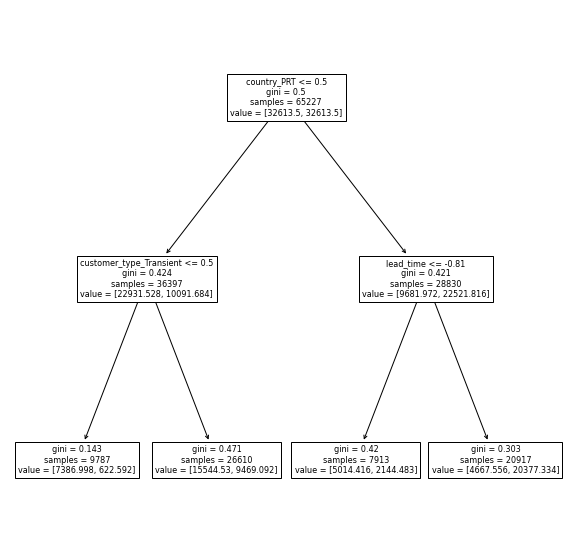

In [35]:
plt.figure(figsize=(10, 10))
tree.plot_tree(model_tree, feature_names=feature_train.columns);

In [36]:
pd.Series(model_tree.feature_importances_, index=feature_train.columns).sort_values(ascending=False)[:5]

country_PRT                0.555793
lead_time                  0.323495
customer_type_Transient    0.120712
country_MYS                0.000000
country_MEX                0.000000
dtype: float64

Модель считает ненадежными клиентами португальцев с типом заказчика 'Transient', а также клиентов, с большим количеством дней между датой бронирования и датой прибытия. К самому важному признаку относится принадлежность к гражданству Португалии (0.55), затем идет количество дней между датой бронирования и датой прибытия (0.32) и тип заказчика 'Transient' (0.12).

Посмотрим на количество отмен брони по категориальным данным:

In [37]:
for column in object_list:
    print(column)
    display(hotel_train[hotel_train['is_canceled'] == 1] \
            .pivot_table(index=[column], values='is_canceled', aggfunc='count') \
            .sort_values(by='is_canceled', ascending=False)[:15])

arrival_date_month


,is_canceled
arrival_date_month,
October,3566
September,3487
August,2597
July,2221
June,1931
December,1913
April,1886
November,1824
May,1673


meal


,is_canceled
meal,
BB,18935
HB,2808
SC,1990
FB,311


country


,is_canceled
country,
PRT,16604
ESP,1081
GBR,938
FRA,876
ITA,767
DEU,541
BRA,349
IRL,313
CHN,234


distribution_channel


,is_canceled
distribution_channel,
TA/TO,22006
Direct,1188
Corporate,831
GDS,19


reserved_room_type


,is_canceled
reserved_room_type,
A,19722
D,2871
E,608
F,348
B,261
G,191
C,43


customer_type


,is_canceled
customer_type,
Transient,18017
Transient-Party,4913
Contract,1090
Group,24


Посмотрим на количество не отмененных бронирований по категориальным данным:

In [38]:
for column in object_list:
    print(column)
    display(hotel_train[hotel_train['is_canceled'] == 0] \
            .pivot_table(index=[column], values='is_canceled', aggfunc='count') \
            .sort_values(by='is_canceled', ascending=False)[:15])

arrival_date_month


,is_canceled
arrival_date_month,
October,5688
September,5295
August,4081
November,3937
December,3584
July,3497
May,3004
April,2918
March,2871


meal


,is_canceled
meal,
BB,32760
HB,4484
SC,3799
FB,140


country


,is_canceled
country,
PRT,12226
FRA,5098
GBR,4170
ESP,3819
DEU,3346
ITA,1560
IRL,1132
BEL,1037
NLD,977


distribution_channel


,is_canceled
distribution_channel,
TA/TO,32447
Direct,5665
Corporate,2991
GDS,80


reserved_room_type


,is_canceled
reserved_room_type,
A,30778
D,6515
E,1840
F,865
B,599
G,401
C,185


customer_type


,is_canceled
customer_type,
Transient,27475
Transient-Party,11789
Contract,1656
Group,263


Большинство отмен брони происходит среди клиентов:
- выбравших тип питания 'BB' (19 тыс. из 24 тыс.);
- с гражданством 'PRT' (16.6 тыс.);
- забронировавших номер категории 'A' (19.7 тыс.);
- через 'TA/TO' (22 тыс.);
- тип заказчика 'Transient' (18 тыс.).

Отмена брони не сильно зависит от сезона, наблюдается повышение количества отмен с июля по октябрь, но разница не такая большая, как между другими категориями.

По состоявшимся заселениям картина схожая:
- выбравших тип питания 'BB' (32.7 тыс. из 41 тыс.);
- с гражданством 'PRT' (12.2 тыс.);
- забронировавших номер категории 'A' (30.7 тыс.);
- через 'TA/TO' (32.4 тыс.);
- тип заказчика 'Transient' (27.4 тыс.).

Посмотрим на корреляцию между отменой брони и количественными признаками:

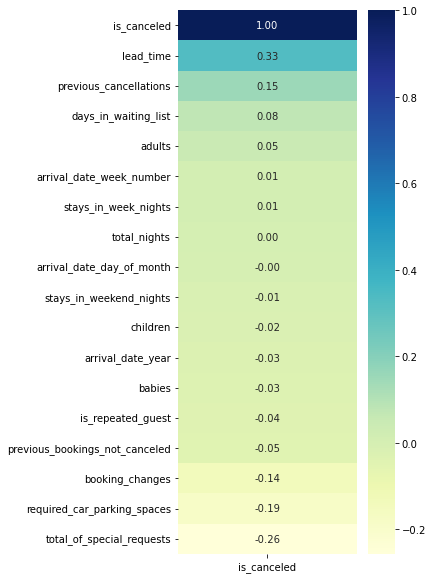

In [39]:
plt.figure(figsize=(4,10))
sns.heatmap(hotel_train
             .corr()[['is_canceled']]
             .sort_values(by='is_canceled', ascending=False), cmap="YlGnBu", annot=True, fmt='.2f'
            );

С отменой брони напрямую коррелирует количество дней между датой бронирования и датой прибытия (коэффициент Пирсона 0.33) - чем больше это значение, тем выше вероятность отмены брони, аналогично, но в меньшей степени влияет количество отменённых заказов у клиента (0.15) и количество дней подтверждения брони (0.08). 

Обратная корреляция у отмены брони сильнее всего с количеством специальных требований (-0.26), необходимостью парковочного места (-0.19) и количеством изменений параметров заказа (-0.14) - чем выше эти значения, тем ниже вероятность отмены брони.

**Вывод:**

Признаки ненадежного клиента, выбранные моделью и полученные с помощью анализа данных вручную не противоречат друг другу:

- тип питания 'BB' (19 тыс. из 24 тыс.);
- гражданство 'PRT' (16.6 тыс.);
- номер категории 'A' (19.7 тыс.);
- канал сбыта 'TA/TO' (22 тыс.);
- тип заказчика 'Transient' (18 тыс.);
- большой срок между датой бронирования и датой прибытия;
- большое количество отмененных заказов у клиента;
- большое количество дней подтверждения брони.

## Общий вывод

* наилучший показатель F1-меры показала модель решающего дерева (0.66 в среднем при кросс-валидации, 0.55 на тестовой выборке), метрика ROC-AUC для на нее составила 0.74;
* внедрение модели окупится и принесет компании более 6,2 млн. руб. за год (по данным из тестовой выборки);
* модель относит к ненадежным клиентам португальцев с типом заказчика 'Transient', а также клиентов, с большим количеством дней между датой бронирования и датой прибытия;
* признаки ненадежного клиента выделенные в ходе анализа:
  - тип питания 'BB' (19 тыс. из 24 тыс.);
  - гражданство 'PRT' (16.6 тыс.);
  - номер категории 'A' (19.7 тыс.);
  - канал сбыта 'TA/TO' (22 тыс.);
  - тип заказчика 'Transient' (18 тыс.);
  - большой срок между датой бронирования и датой прибытия;
  - большое количество отмененных заказов у клиента;
  - большое количество дней подтверждения брони.